<a href="https://colab.research.google.com/github/VoKhoiNhon/TimeSerisesForecasting/blob/main/TimeSeries_Gold_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML 

Mounted at /content/drive
/content/drive/MyDrive/ML


**import thu vien
**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = (14,8)
sns.set_style('darkgrid')
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('gold.csv')
df.Date = pd.to_datetime(df.Date,dayfirst=True)
df.set_index('Date',inplace=True)
df = df.asfreq('b','ffill')
del df['Currency']
df.tail(10)

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-22,1760.6,1762.10,1740.20,1748.4,142857
2022-08-23,1750.0,1767.50,1743.10,1761.2,145260
2022-08-24,1761.3,1769.50,1754.80,1761.5,112645
2022-08-25,1764.4,1778.80,1763.00,1771.4,117570
2022-08-26,1771.8,1772.30,1746.20,1749.8,176904
2022-08-29,1748.4,1757.90,1731.40,1749.7,156220
2022-08-30,1749.8,1752.80,1732.90,1736.3,130664
2022-08-31,1735.5,1738.00,1720.60,1726.2,176731
2022-09-01,1723.0,1723.00,1699.10,1709.3,198618


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5914 entries, 2000-01-04 to 2022-09-02
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5914 non-null   float64
 1   High    5914 non-null   float64
 2   Low     5914 non-null   float64
 3   Close   5914 non-null   float64
 4   Volume  5914 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 277.2 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5914.0,1038.826835,519.294993,256.6,452.925,1188.10,1380.500,2076.4
High,5914.0,1046.783201,522.932374,259.4,455.425,1197.25,1391.775,2089.2
Low,5914.0,1030.325507,515.005988,255.1,449.750,1178.55,1367.225,2049.0
Close,5914.0,1038.764406,519.082257,256.6,453.050,1187.20,1380.500,2069.4
Volume,5914.0,139219.708150,103366.087891,0.0,52326.500,125509.00,193311.500,816531.0


2. DỮ LIỆU GỐC CHƯA ĐƯỢC RÚT GỌN

Exploratory Data Analysis

In [ ]:
data = df

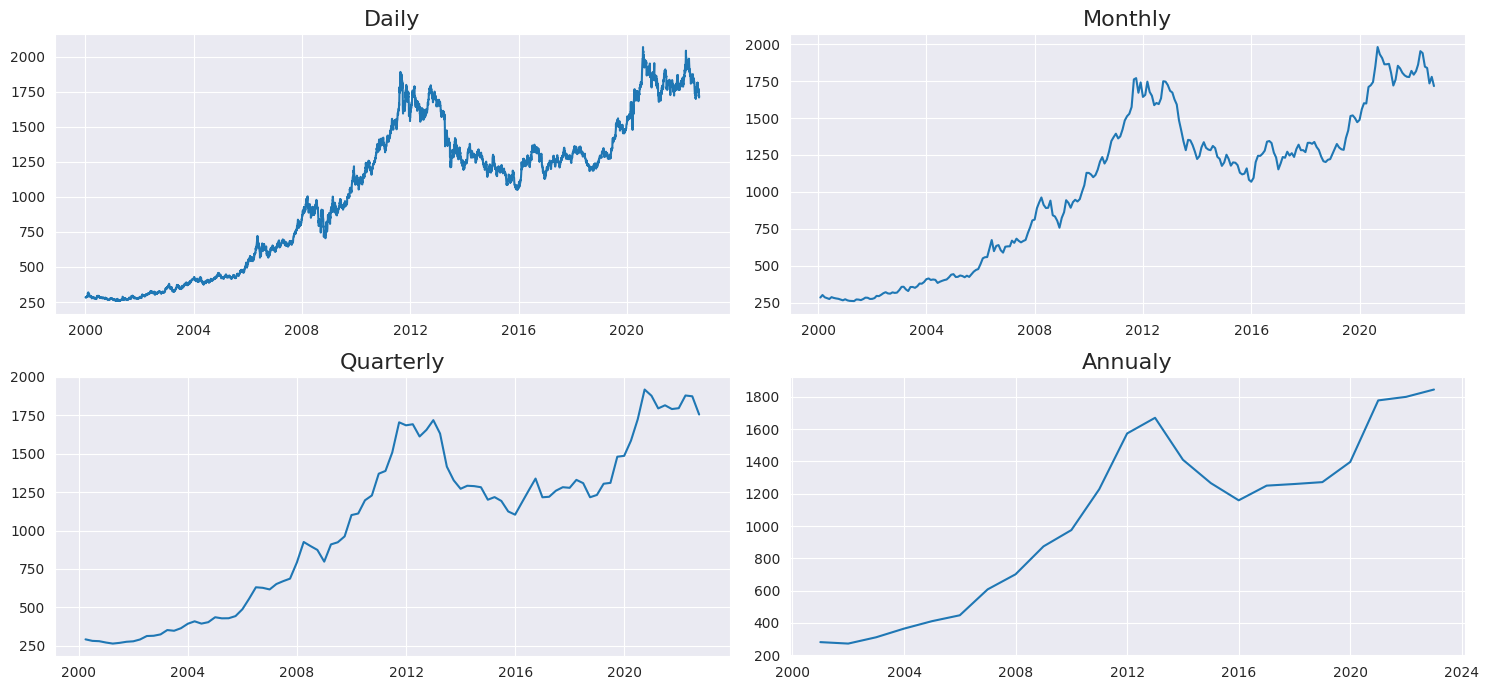

In [ ]:
fig,axes = plt.subplots(2,2,figsize=[15,7])

axes[0,0].plot(data.Close)
axes[0,0].set_title("Daily",size=16)

axes[0,1].plot(data.Close.resample('M').mean())
axes[0,1].set_title("Monthly",size=16)

axes[1,0].plot(data.Close.resample('Q').mean())
axes[1,0].set_title('Quarterly',size=16)

axes[1,1].plot(data.Close.resample('A').mean())
axes[1,1].set_title('Annualy',size=16)

plt.tight_layout()
plt.show()

1. Seasonality

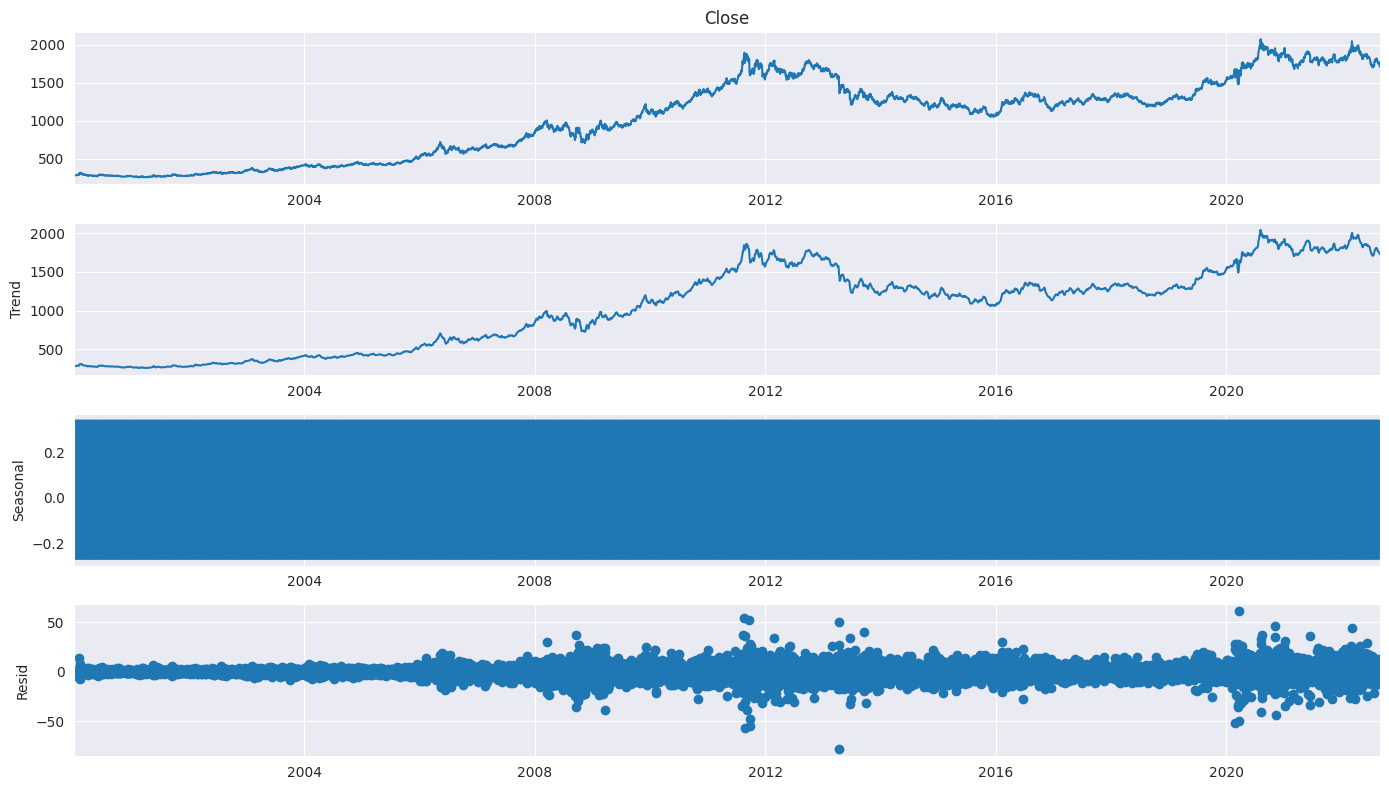

In [ ]:
# data=df[df.index>='2021']
decompose_result = seasonal_decompose(data['Close'])
trend = decompose_result.trend
seasonal = decompose_result.seasonal
cycle  = decompose_result.resid
decompose_result.plot();

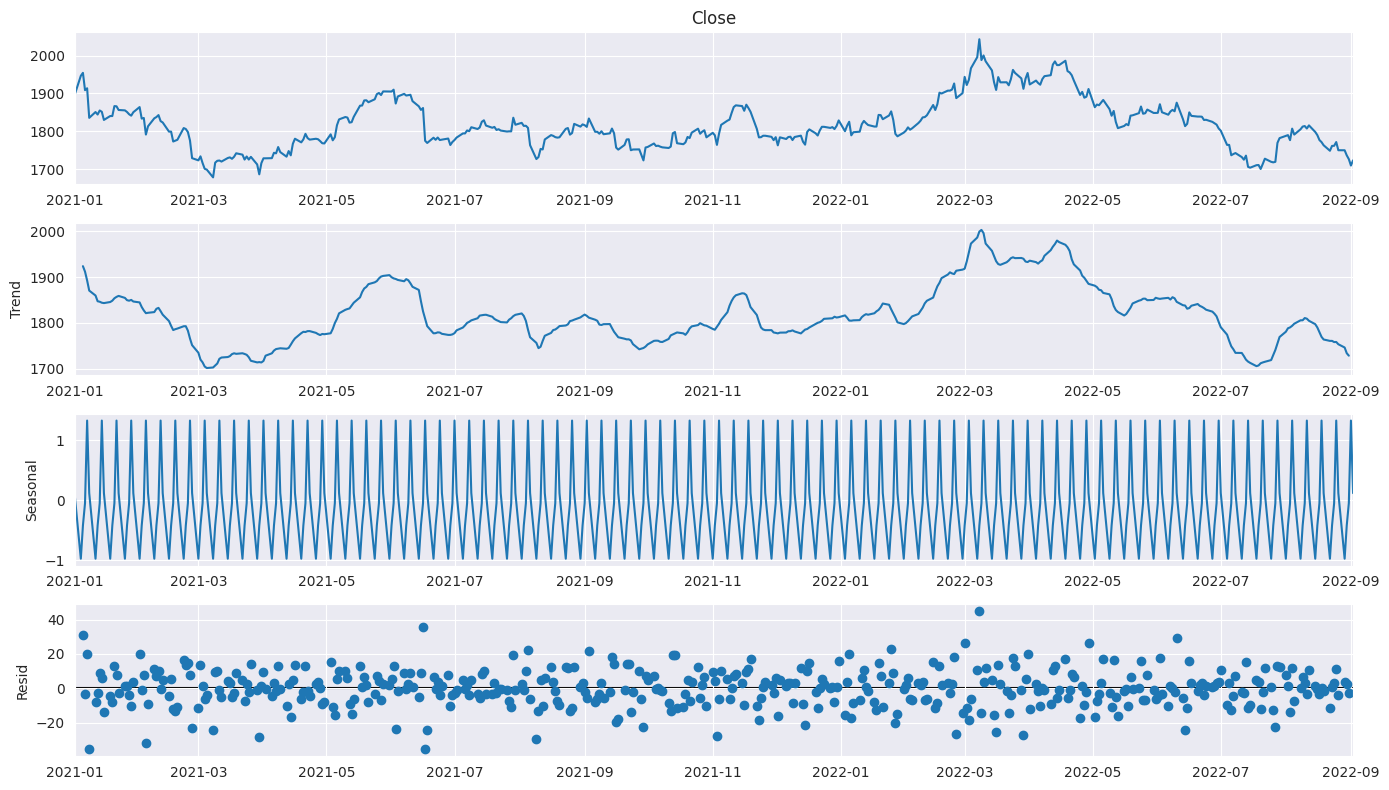

In [ ]:
data=df[df.index>='2021 ']
decompose_result = seasonal_decompose(data['Close'])
trend = decompose_result.trend
seasonal = decompose_result.seasonal
cycle  = decompose_result.resid
decompose_result.plot();

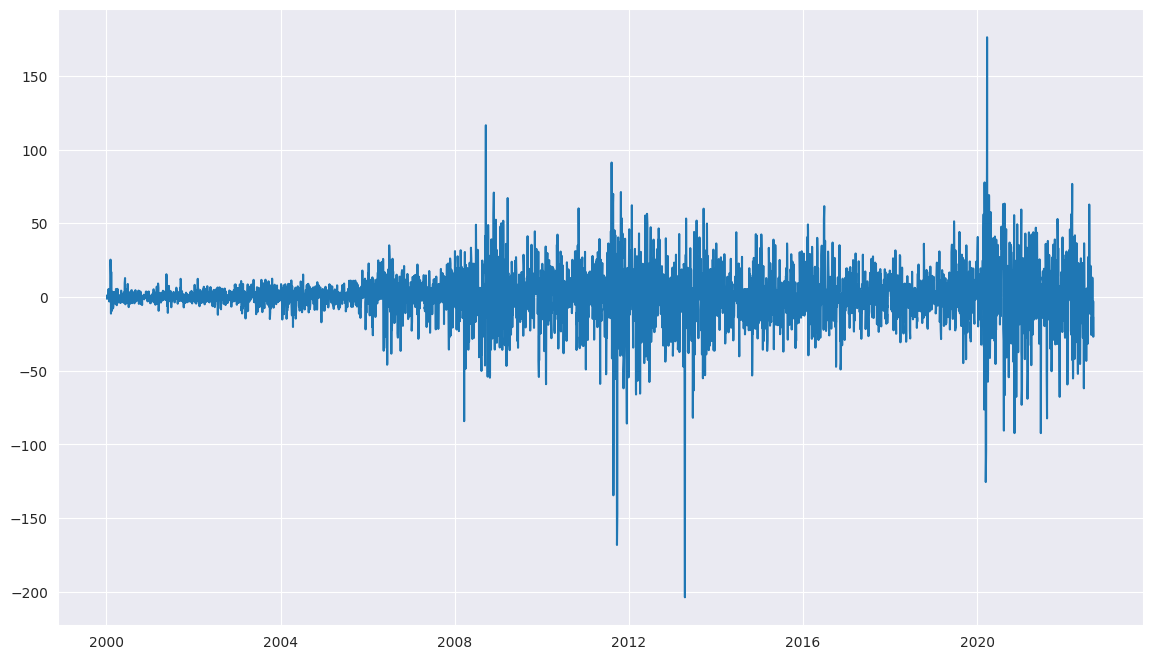

In [ ]:
diff = data.Close.diff(periods=2)
plt.plot(diff)

2.  Stationarity

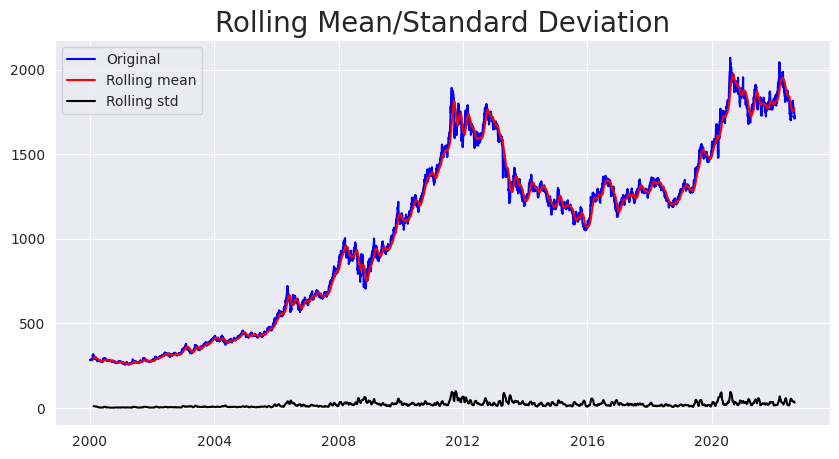

Test Statistic                   -0.837125
p-value                           0.807973
#Lags Used                       33.000000
Number of Observations Used    5880.000000
Critical Value (1%)              -3.431463
Critical Value (5%)              -2.862032
Critical Value (10%)             -2.567032
dtype: float64


In [ ]:
# xác định điểm dừng 
def stationarity_check(series):
    dftest = adfuller(series, autolag='AIC') 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
       
    print(dfoutput)

# hàm xử lí và loại bỏ trend và seasonal để chuổi dừng 
def differencing(s, interval=1):
  diff = [s[i]-s[i-interval] for i in range(interval, len(s))]
  return diff

def plot_rolling_stats(series,window):
    # Tính trung bình trượt và độ lệch 
    rol_mean = series.rolling(window).mean()
    rol_std  = series.rolling(window).std()
    
    fig = plt.figure(figsize=(10,5))
    orig = plt.plot(series,color='blue',label='Original')
    mean = plt.plot(rol_mean,color='red',label='Rolling mean')
    std  = plt.plot(rol_std,color='black',label='Rolling std')
    
    plt.title('Rolling Mean/Standard Deviation',size=20)
    plt.legend(loc='best')
    plt.show(block=False)

plot_rolling_stats(data.Close,30)
stationarity_check(data.Close)

In [ ]:
ds_1 = differencing(data.Close, 2)
stationarity_check(ds_1 )

Test Statistic                -1.452897e+01
p-value                        5.370322e-27
#Lags Used                     3.200000e+01
Number of Observations Used    5.880000e+03
Critical Value (1%)           -3.431463e+00
Critical Value (5%)           -2.862032e+00
Critical Value (10%)          -2.567032e+00
dtype: float64


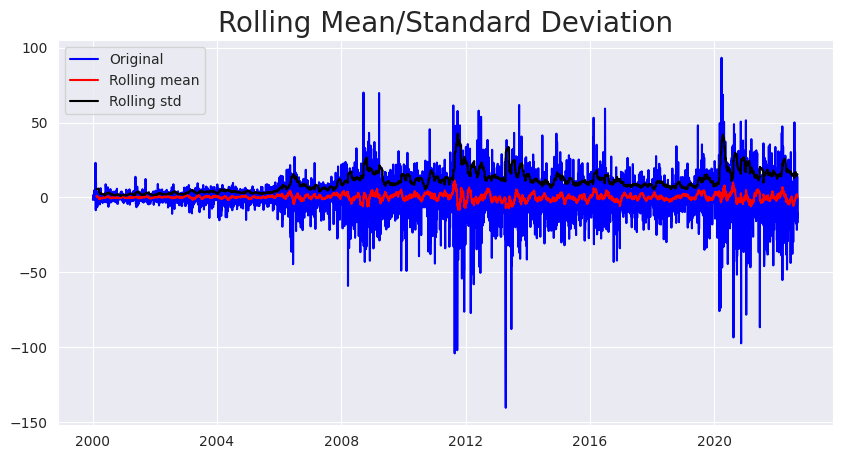

Test Statistic                -1.452897e+01
p-value                        5.370322e-27
#Lags Used                     3.200000e+01
Number of Observations Used    5.880000e+03
Critical Value (1%)           -3.431463e+00
Critical Value (5%)           -2.862032e+00
Critical Value (10%)          -2.567032e+00
dtype: float64


In [ ]:
## regular differentiation
plot_rolling_stats(data.Close.diff()[1:],30)
stationarity_check(data.Close.diff()[1:])

<Axes: xlabel='Date'>

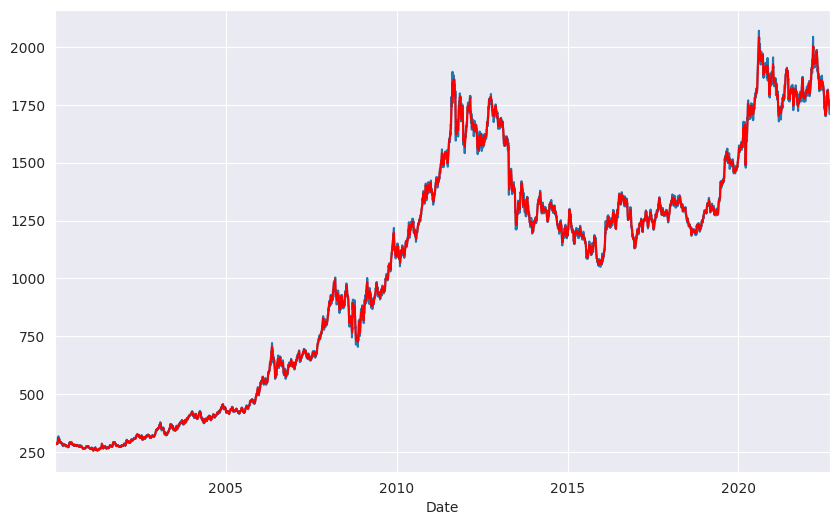

In [ ]:
detrended = data.Close - decompose_result.seasonal- decompose_result.resid

ax = data.Close.plot(figsize=(10,6))
detrended.plot(ax=ax, color='red')

Autocorrelation and Partial Autocorrelation

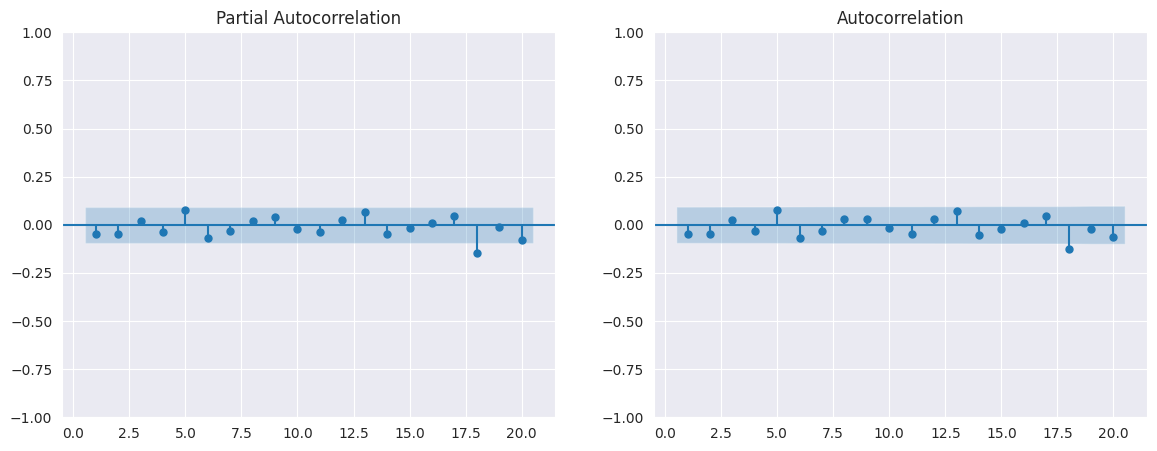

In [ ]:
#auto
data=df[df.index>='2021']
fig = plt.figure(figsize=(14,5))
ax_1 = fig.add_subplot(121)
plot_pacf(data.Close.diff()[1:],lags=20,zero=False,ax=ax_1)

ax_2 = fig.add_subplot(122)
plot_acf(data.Close.diff()[1:],lags=20,zero=False,ax=ax_2);

**Forecasting**

In [ ]:
train_len = int(data.shape[0]*0.80)
train = data[0:train_len] 
test = data[train_len:] 

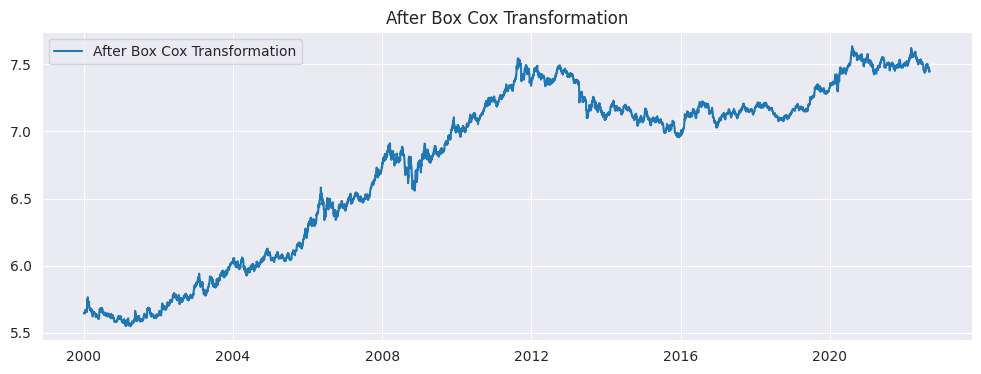

In [ ]:

data_boxcox = pd.Series(boxcox(data['Close'], lmbda = 0), index = data.index)
plt.figure(figsize = (12, 4))
plt.plot(data_boxcox, label = 'After Box Cox Transformation')
plt.legend(loc = 'best')
plt.title('After Box Cox Transformation')
plt.show()

In [ ]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

In [ ]:
train_data_boxcox.tail()

In [ ]:
model = ARIMA(train_data_boxcox, order=(2, 2, 1)) 
model_fit = model.fit()

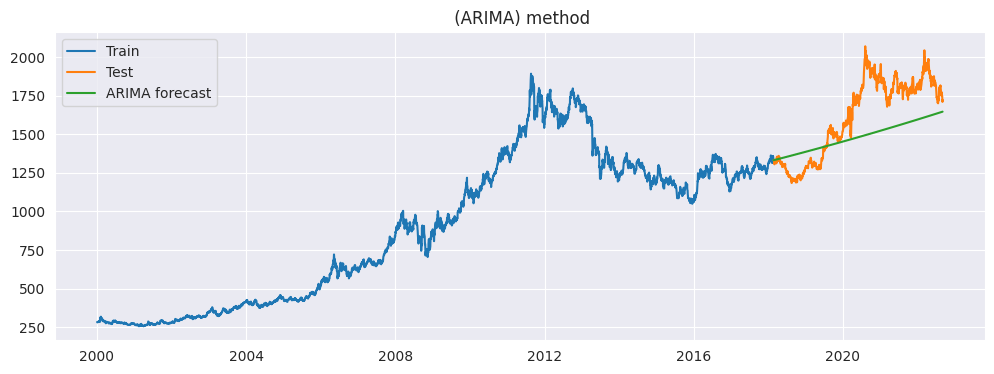

In [ ]:
y_hat_arima = test_data_boxcox.copy()
y_hat_arima['arima_forecast_boxcox'] = model_fit.predict(test_data_boxcox.index.min(), test_data_boxcox.index.max())
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

plt.figure(figsize=(12,4))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title(' (ARIMA) method')
plt.show()

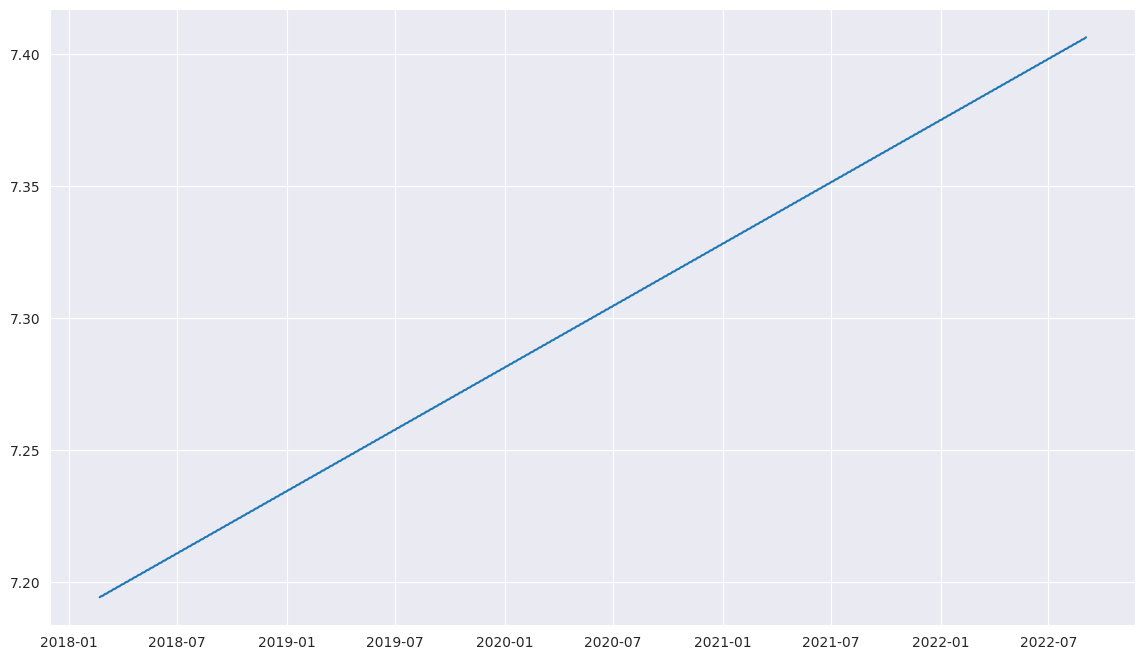

In [ ]:

predictions = []
model = ARIMA(train_data_boxcox,order=(2,2,1)).fit()
forecast=model.forecast(steps=len(test_data_boxcox))
plt.plot(forecast)

In [ ]:
print(forecast)

2018-02-21    7.194227
2018-02-22    7.194406
2018-02-23    7.194583
2018-02-26    7.194763
2018-02-27    7.194942
                ...   
2022-08-29    7.405445
2022-08-30    7.405624
2022-08-31    7.405803
2022-09-01    7.405983
2022-09-02    7.406162
Freq: B, Name: predicted_mean, Length: 1183, dtype: float64


In [ ]:
class Data:
    def __init__(self,dataset,window,forecast_steps=1):
        self.dataset = dataset
        self.window = window
        self.steps = forecast_steps
        self.index = 0
    
    def get_train(self):
        training_data = self.dataset[self.index:self.index+self.window]
        return training_data.values
    
    def get_test(self):
        test_index = self.index+self.window
        test_data = self.dataset[test_index:test_index+self.steps]
        return test_data.values
    
    def get_data(self):
        train = self.get_train() 
        test  = self.get_test()
        self.index+= self.steps
        return train, test

In [ ]:
steps = 1 ## ngày tiếp theo
window = 5 ## số ngày làm việc(giá càng hiển thị trên tuần)

iterations = int(len(data.Close[window:])/steps)
predictions = []

dataset = Data(data.Close,window,steps)
for _ in range(iterations):
  train,test = dataset.get_data()
  model = ARIMA(train,order=(2,2,1)).fit()
  predictions.append(model.forecast(steps=steps)[0])


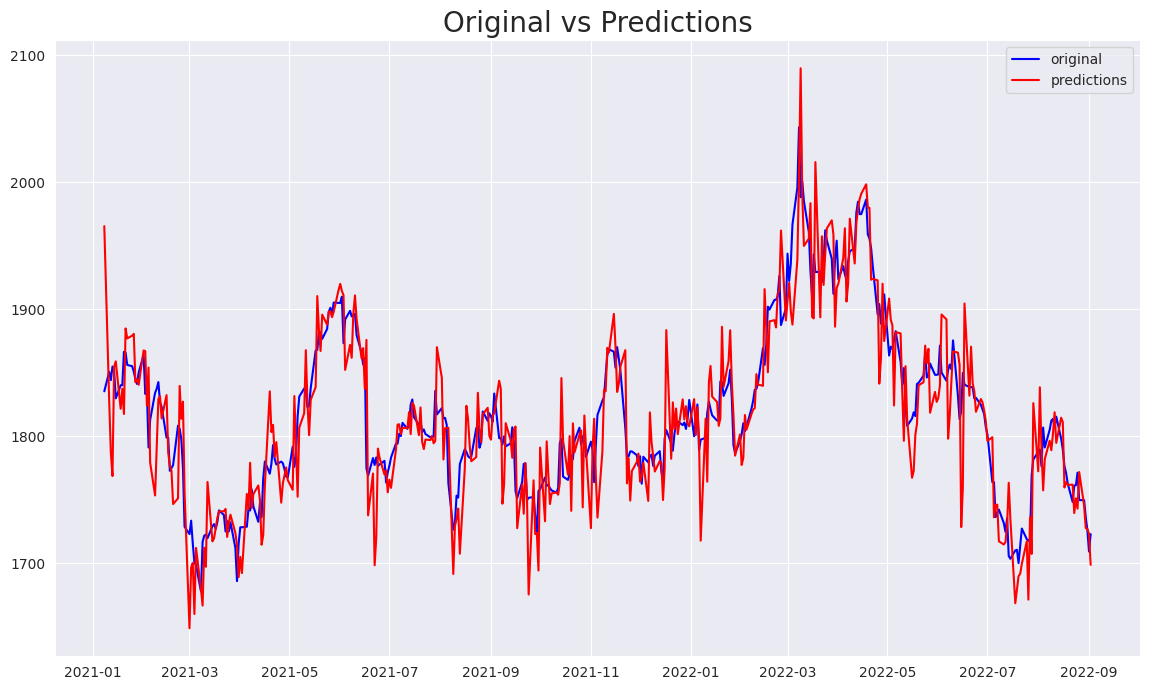

In [ ]:
# ngày bắt đầu là 2021-01-08 vì ngày làm việc đầu tiên của năm 2021 là ngày 1 tháng 1
# và dự báo luân phiên sử dụng 5 ngày "tuần làm việc", Tuy nhiên, ngày 6 và 7 tháng 1 là ngày nghỉ.
date_index = pd.date_range(start='2021-01-08',end='2022-09-02',freq='b') 
df_pred = pd.DataFrame({'predictions':predictions},index=date_index)

plt.plot(data.Close[window:],color='blue',label='original')
plt.plot(df_pred,color='red',label='predictions')


plt.title('Original vs Predictions',size=20)
plt.legend(loc='best');